In [3]:
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# Regex
import re


## Introdução

Foi proposto um desafio pela empresa Data Sprints como um desafio técnico para a área da engenharia de dados. O desafio consiste na utilização de uma mistura de Python com SQL para realização de uma modelagem de dados em conjunto com uma análise desses dados que ocorrerá posteriormente.

Os dados que foram providenciados se referem a corridas de taxi que ocorreram entre *2009* e 2012** em Nova York. Esses dados estão divididos em quatro arquivos e cada um deles possui, aproximadamente, 400MB.

Além desses dados referentes as corridas, também existem dois datasets com informações a respeito das empresas de taxi e com relação aos meios de pagamento.

Com esse intuito, pretendo utilizar a seguinte abordagem para a realização da modelagem de dados:

1. Obtenção de uma amostra pequena desses dados para que possa ser realizada uma comparação entre os queries que utilizarei para realizar a modelagem final com os resultados obtidos utilizando Pandas. A biblioteca Pandas é mais flexível no processo de análise de dados, no entanto, o processamento de grandes bases de dados se torna lenta, apesar de ser possível.
2. Será criada um banco de dados de desenvolvimento para prototipagem do banco de dados. Para tanto, será utilizado o banco de dados *PostgresSQL*
3. Após a validação do modelo que será utilizado, assim como as consultas que serão realizadas ao banco de dados para extração das informações que foram solicitadas, será utilizado um cluster da ferramenta Amazon Redshift para realização do mesmo processo com todos os dados fornecidos.


## Exploração Inicial dos dados

Dentre as informações que podem ser obtidas através da análise desses dados, algumas informações são mais importantes para a empresa Data Sprints. Sendo elas:
- Distância média percorrida em viagens com até dois passageiros.
- Quantidade arrecada pelas três maiores empresas de taxi
- Distribuição das corridas entre 2009 e 2012 realizadas por passageiros que realizaram o pagamento em dinheiro.
- Quantidade de gorgetas por dia que ocorreram entre Outubro de 2012 e Dezembro de 2012.


Com o intuito de utilizar uma base de dados pequena (de fácil validação) e, ao mesmo tempo, conseguir trabalhar nos queries necessários para responder essas questões utilizarei os dados dos últimos meses do dataset do ano 2012. No entanto, é importante destacar que será necessário outra forma de validação para a terceira pergunta.

Com o intuito de obter a amostragem necessária, será utilizado o método `.sample()` da biblioteca pandas para adquirir 100.000 linhas aleatórias do ano de 2012. Para possibilitar a reprodução das análises que serão realizadas nessa amostra, utilizarei o argumento `random_state=42`.

Os dados adquiridos serão salvos no arquivo `sample.csv`




### Extração da amostra através da utilização do Spark

In [5]:
%time df = pd.read_json('/home/rafael/Downloads/data-sample_data-nyctaxi-trips-2012-json_corrigido.json', lines=True)

CPU times: user 9.76 s, sys: 1.65 s, total: 11.4 s
Wall time: 13.3 s


Uma das vantagens do Spark é porque ele possui um atributo chamado *SchemaOnRead* que tenta inferir os tipo de dados de cada uma das colunas do DataFrame.

Nesse dataframe especificamente, as colunas relacionadas a datas foram transformadas em strings, o que não deveria ocorrer se os dados dessas colunas estivessem em um formato reconhecível pelo Spark.

Através da observação desses valores, pode-se observar que aleḿ das medidas comuns para datas e para o tempo, também está sendo utilizado milissegundos.

Com o intuito de transformar esses valores sem perda de informação, realizarei a conversão desses valores para um timestamp unix. Essa coluna conterá esses valores transformados em uma epoch com milisegundos (básicamente quantos milisegundos passaram desde a epoch `01-01-1970`. Posteriormente, será possível realizar a extração de dados como dia, mês, ano e horário dessas variável.

In [6]:
%%time 
df = df.sample(100000, random_state=42)
df.to_csv('sample_2012.csv', index=False)

CPU times: user 1.52 s, sys: 28 ms, total: 1.54 s
Wall time: 1.68 s


In [7]:
df = pd.read_csv('sample_2012.csv')

#### Parsing Dates

As datas estão disponibilizadas em um formato que não é reconhecido pela biblioteca Pandas. Por conta disso, será criada uma função que utilizará regex para tranformar esses dados em um formato aceito pelo pandas. 

Sendo válido destacar que há dois padrões de representação presente nos dados. Em um dos casos há a inclusão de milisegundos, enquanto no segundo padrão não há.

Os dados serão convertidos para o seguinte formato:  
- `AAAA-MM-DD HH:MM:DD.ffffff`

In [8]:
df['pickup_datetime'].head()

0    2012-02-29T21:36:01.135894+00:00
1    2012-01-10T10:34:22.332916+00:00
2      2012-08-03T04:18:55.3544+00:00
3    2012-09-05T02:59:10.862789+00:00
4     2012-09-15T04:04:42.71513+00:00
Name: pickup_datetime, dtype: object

In [9]:
import datetime

def parsing_date(value):
    value = value.replace('T', ' ').replace('+00:00', '')
    
    if re.match('(\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}.\d{1,6}$)', value):
        date = datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S.%f")
        
    else:
        date = datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S")
        
    return date


date_columns = ['dropoff_datetime','pickup_datetime']
for column in date_columns:
    df[column] = pd.to_datetime(df[column].map(parsing_date))

In [10]:
dataset_information = []
for column in df:
    dataset_information.append({
        'column': column,
        'max_size': df[column].map(str).map(len).max(),
        'type': df[column].dtype,
        'not_unique_percent': df[column].duplicated().sum() / len(df)
    })
        
    

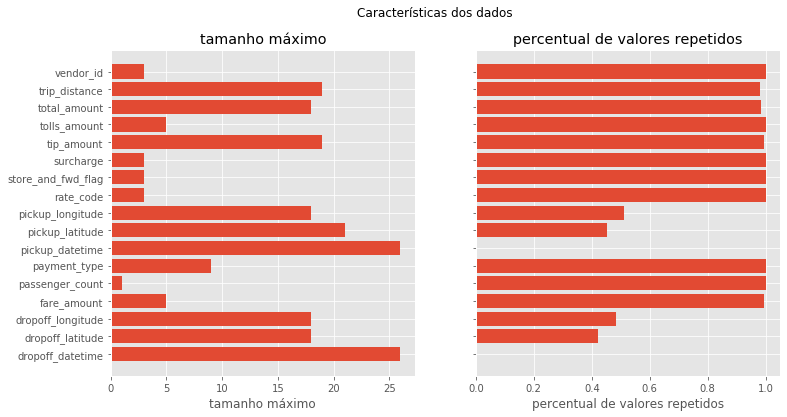

In [11]:
dataset_information = pd.DataFrame(dataset_information)

fig, ax = plt.subplots(figsize=(12,6), ncols=2, sharey=True)


ax[0].barh(dataset_information['column'], dataset_information['max_size'])
ax[1].barh(dataset_information['column'], dataset_information['not_unique_percent'])

ax[0].set_xlabel('tamanho máximo')
ax[1].set_xlabel('percentual de valores repetidos')

ax[0].set_title('tamanho máximo')
ax[1].set_title('percentual de valores repetidos')

plt.suptitle('Características dos dados')
plt.show()

A partir da análise das informações acima, será possível estabelecer o tipo de dados que será utilizado no banco de dados tanto para colunas numéricas, como para textos.

Um ponto importante é que as únicas colunas em que todos os valores são únicos são referentes as datas por conta da precisão em milisegundos de cada uma das corridas.


#### Tipos de dados

In [12]:
dataset_information[['column','type']]

,column,type
0,dropoff_datetime,datetime64[ns]
1,dropoff_latitude,float64
2,dropoff_longitude,float64
3,fare_amount,float64
4,passenger_count,int64
5,payment_type,object
6,pickup_datetime,datetime64[ns]
7,pickup_latitude,float64
8,pickup_longitude,float64
9,rate_code,float64


Com o intuito de evitar possíveis problemas, será feita uma análise das colunas que estão sendo utilizadas como texto (object).

In [13]:
df.groupby('payment_type').count()['vendor_id']

payment_type
CASH         42044
CREDIT         966
Cash         39152
Credit       17488
Dispute         53
No Charge      297
Name: vendor_id, dtype: int64

### Tabela 01:  Trips

In [14]:
import psycopg2

conn = psycopg2.connect("host=localhost user=******* password=********* dbname=datasprints port=5432")
conn.set_session(autocommit=True)

cur = conn.cursor()

cur.execute("DROP TABLE IF EXISTS trips")

cur.execute("""
CREATE TABLE IF NOT EXISTS trips (
    fim_datetime       TIMESTAMP,
    fim_latitude       DECIMAL(9,6),
    fim_longitude      DECIMAL(9,6),
    bandeira           NUMERIC,
    qt_passageiros     INT,
    forma_de_pagamento VARCHAR(20),
    inicio_datetime    TIMESTAMP,
    inicio_latitude    DECIMAL(9,6),
    inicio_longitude   DECIMAL(9,6),
    rate_code          NUMERIC,
    store_and_fwd_flag NUMERIC,
    sobretaxa          NUMERIC,
    gorgeta_valor      NUMERIC,
    valor_pedagio      NUMERIC,
    valor_total        NUMERIC,
    distancia_total    NUMERIC,
    vendor_id          CHAR(3),
    PRIMARY KEY (inicio_datetime, fim_datetime)
    )
""")

### Tabela 02: Vendors

In [15]:
pd.read_csv('lookups/data-vendor_lookup-csv.csv')

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes
3,TS,Total Solutions Co,Five Boroughs Taxi Co.,Brooklyn,NY,11229,USA,mgmt@5btc.com,Yes
4,MT,Mega Taxi,4 East Jennings St.,Brooklyn,NY,11228,USA,contact@megataxico.com,No


In [17]:
cur.execute("DROP TABLE IF EXISTS vendors")

cur.execute("""
CREATE TABLE IF NOT EXISTS vendors (
    vendor_id  VARCHAR(3) PRIMARY KEY,
    nome       VARCHAR(60),
    endereco   VARCHAR(60),
    cidade     VARCHAR(40),
    estado     CHAR(2),
    cep        CHAR(5),
    pais    CHAR(3),
    contato    VARCHAR(50),
    current    VARCHAR(3)
)
""")


vendors = pd.read_csv('lookups/data-vendor_lookup-csv.csv')
for index, row in vendors.iterrows():
    cur.execute("""
    INSERT INTO vendors (vendor_id, nome, endereco, cidade, estado, cep, pais, contato, current)
    VALUES (%s, %s, %s, %s, %s, %s, %s,  %s, %s)
    """, list(row))

In [18]:
ls lookups

data-payment_lookup-csv.csv*  data-vendor_lookup-csv.csv*


### Homogeneização da variável payment_type

In [19]:
# transformando o arquivo que contêm os valores a serem mapeados usando funções do linux.
!head -19 'lookups/data-payment_lookup-csv.csv' | tail -17 > 'payment.csv'


# transformando os valores em um dicionário
lockup_payments = pd.read_csv('payment.csv', header=None)
lockup_payments = dict(zip(lockup_payments[0], lockup_payments[1]))


# utilizando o dicionário para a uniformização da variável payment_type
df['payment_type'] = df['payment_type'].map(lockup_payments)

df['payment_type'].value_counts()

Cash         81196
Credit       18454
No Charge      297
Dispute         53
Name: payment_type, dtype: int64

### Inserção dos valores na tabela

In [20]:
df['rate_code'] = np.where(df['rate_code'].isnull(), None, df['rate_code'])
df['store_and_fwd_flag'] = np.where(df['store_and_fwd_flag'].isnull(), None, df['store_and_fwd_flag'])

In [21]:
df.to_csv('sample_new.csv', index=False, header=False, )

with open('sample_new.csv', 'r') as f:
    cur.copy_from(f, 'trips', sep=',', null="")

In [22]:
cur.execute("SELECT COUNT(*) FROM trips")
results = cur.fetchone()
print(results)

(100000,)


### Distância média percorrida em viagens com até dois passageiros

Um fato estranho é que existem algumas corridas em que não houve passageiros. No entanto, como essas observações apresentam alguns valores não nulos, tais como deslocamento (longitude - latitude) e pagamento do valor da bandeira, provavelmente, se trata de observações válidas.

In [23]:
df[df['passenger_count'] <= 2]['passenger_count'].value_counts()

1    64558
2    18266
0       10
Name: passenger_count, dtype: int64

In [24]:
result_pandas = df[df['passenger_count'] <= 2].mean()['trip_distance']

cur.execute("SELECT AVG(distancia_total) FROM trips WHERE qt_passageiros <= 2")
results_db = cur.fetchone()

assert round(float(results_db[0]), 3) == round(result_pandas, 3)

In [25]:
results_db

(Decimal('2.65185975565589010'),)

### Distribuição de corridas pagas em dinheiro

In [26]:
month = df[df['payment_type'] == 'Cash'].set_index('pickup_datetime').resample('m').count()['dropoff_datetime']

month.index = month.index.month
month = month.reset_index()
month = month.rename({'pickup_datetime':'mes', 'dropoff_datetime':'numero_de_corridas'}, axis=1)

cur.execute("""
SELECT EXTRACT(month FROM inicio_datetime) AS month,
      COUNT(*)
FROM trips
WHERE forma_de_pagamento = 'Cash'
GROUP BY 1
""")
a = cur.fetchall()


values_db = pd.DataFrame(list(a)).rename({0: 'mes', 1: 'numero_de_corridas'}, axis=1)
values_db['mes'] = values_db['mes'].astype('int')

assert month.equals(values_db)

### Quantidade total arrecadada por empresa

In [27]:
vendor_total = df.groupby('vendor_id').sum()['total_amount'].reset_index().sort_values(by='total_amount', 
                                                                                       ascending=False)

cur.execute("""
SELECT nome, SUM(valor_total)
FROM trips t
JOIN vendors v
ON t.vendor_id = v.vendor_id
GROUP BY 1
ORDER BY 2 DESC
""")
results = cur.fetchall()
results = pd.DataFrame(results).rename({0:'nome',1:'total_amount'}, axis=1)
results['total_amount'] = round(results['total_amount'].astype('float'), 2)

print("Valores obtidos utilizando pandas\n")
print(vendor_total)
print("Valores obtidos utilizando a database\n")
print(results)

Valores obtidos utilizando pandas

  vendor_id  total_amount
0       CMT     486849.66
2       VTS     469911.34
1       DDS      68757.38
Valores obtidos utilizando a database

                                nome  total_amount
0  Creative Mobile Technologies, LLC     486849.66
1                       VeriFone Inc     469911.34
2     Dependable Driver Service, Inc      68757.38


##

In [46]:
cur.execute("""
SELECT EXTRACT(dow from t1.inicio_datetime), AVG(t1.tempo_total)
FROM (SELECT (EXTRACT(epoch FROM fim_datetime) - EXTRACT(epoch FROM inicio_datetime)) / 60 AS tempo_total,
        inicio_datetime
    FROM trips) t1
WHERE EXTRACT(dow from t1.inicio_datetime) IN (0.0, 6.0)
GROUP BY 1
""")
results = cur.fetchall()

results = pd.DataFrame(results)

# os domingos são representados como 0 na função dow, enquanto os sábados são representados com o valor 6.

results[0] = results[0].map({6.0: 'Sábado', 0.0: 'Domingo'})
results = results.rename({0.0: 'dia_da_semana', 1.0: 'tempo_médio'}, axis=1)


df['tempo_corrida_minutos'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
df['weekday'] = df['pickup_datetime'].dt.weekday
df['weekday'] = df['weekday'].map({5.0: 'Sábado', 6.0: 'Domingo'})




#### Resultados no Pandas

In [49]:
print(df.groupby('weekday').mean()['tempo_corrida_minutos'])

weekday
Domingo    8.985822
Sábado     8.989026
Name: tempo_corrida_minutos, dtype: float64


#### Resultados no PostgreSQL

In [48]:
print(results)

  dia_da_semana  tempo_médio
0       Domingo     8.985822
1        Sábado     8.989026


(0, 200)

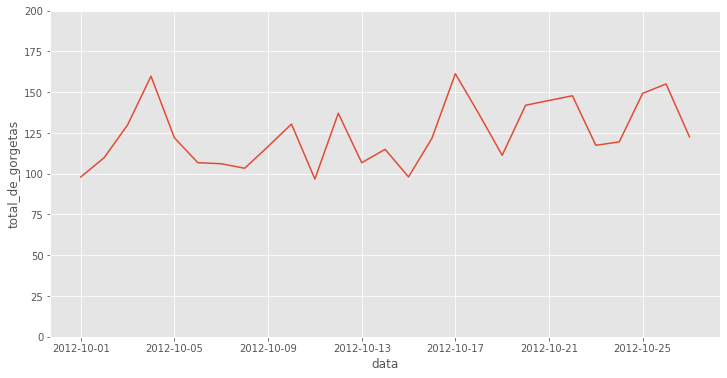

In [38]:
cur.execute("""
SELECT inicio_datetime::date, SUM(gorgeta_valor)
FROM trips
WHERE EXTRACT(month FROM inicio_datetime) >= 10
AND EXTRACT(year FROM inicio_datetime) = 2012
GROUP BY 1
""")
results = cur.fetchall()
results = pd.DataFrame(results).rename({0: 'data', 1: 'total_de_gorgetas'}, axis=1)
results['total_de_gorgetas'] = results['total_de_gorgetas'].astype('float')

plt.figure(figsize=(12,6))
sns.lineplot(data=results, x='data', y='total_de_gorgetas')
plt.ylim(0, 200 )